In [2]:
import sys
sys.path.append('/opt/conda/pkgs')
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/4262b1bf4bf1ffb403c0eb7a42ad5906_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/4506eccf78279d93d0e8a34c035e91c5_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/6bda807e3967eae797c7b1b9eeaee8db_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/c2a47d89d1d34e789fdf782557bb7194_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/c6c5514ada15b890fb27d1e36371554c_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/d964a294c2d0fef56a434c021026281e_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/e1c932db5cd4271709e54d8028824bc9_/lib/python3.12/site-packages")
import pickle, os, gzip, json, sys, itertools
from pathlib import Path
from importlib import reload
from dataclasses import dataclass, field
import collections
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pysam
import scipy as sp
import seaborn
import sharedmem

plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["figure.dpi"] = 300


sys.path.append("scripts")
sys.path.append("../../scripts")



In [3]:
from data_io import is_fwd_id, get_fwd_id, get_sibling_id
from dim_reduction import SpectralEmbedding, scBiMapEmbedding
from nearest_neighbors import (
    ExactNearestNeighbors,
    NNDescent,
    WeightedLowHash,
    PAFNearestNeighbors,
    LowHash,
    HNSW,
    ProductQuantization,
    _NearestNeighbors,
    IVFProductQuantization,
)
from graph import OverlapGraph, GenomicInterval, get_overlap_statistics, remove_false_edges
from truth import get_overlaps
from evaluate import NearestNeighborsConfig, mp_compute_nearest_neighbors
from plots import plot_read_graph, mp_plot_read_graphs, get_graphviz_layout, get_umap_layout

/home/miaocj/docker_dir/kNN-overlap-finder/scripts/../lib


## Parameters


In [3]:
MAX_SAMPLE_SIZE = int(1e9)
COVERAGE_DEPTH = 20
max_bucket_size = COVERAGE_DEPTH * 1.5

## Load data

In [8]:

npz_path = "/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/CHM13/HLA/pbsim_ONT_93_30k/kmer_k16/feature_matrix.npz"
tsv_path = "/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/CHM13/HLA/pbsim_ONT_93_30k/kmer_k16/metadata.tsv.gz"
json_path = "/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/CHM13/HLA/pbsim_ONT_93_30k/kmer_k16/read_features.json.gz"
paf_path = "/home/miaocj/docker_dir/kNN-overlap-finder/data/minimap2/CHM13/HLA/pbsim_ONT_93_30k/alignment.paf.gz"

output_folder = "/home/miaocj/docker_dir/kNN-overlap-finder/data/evaluation/CHM13/HLA/pbsim_ONT_93_30k/kmer_k16/"

threads  = 8


In [9]:
meta_df = pd.read_table(tsv_path).iloc[:MAX_SAMPLE_SIZE, :].reset_index()
read_indices = {read_name: read_id for read_id, read_name in meta_df['read_name'].items()}

feature_matrix = sp.sparse.load_npz(npz_path)[meta_df.index, :]

with gzip.open(json_path, "rt") as f:
    read_features = json.load(f)
    read_features = {i: read_features[i] for i in meta_df.index}

feature_weights = {i: 1 for i in range(feature_matrix.shape[1])}

kw = dict(data=feature_matrix)
max_bucket_size = COVERAGE_DEPTH * 1.5

In [10]:
variances = [np.std(read_features[i]) for i in range(1000,1100)] 
means = [np.mean(read_features[i]) for i in range(1000,1100)] 
average_variance = np.mean(variances)  


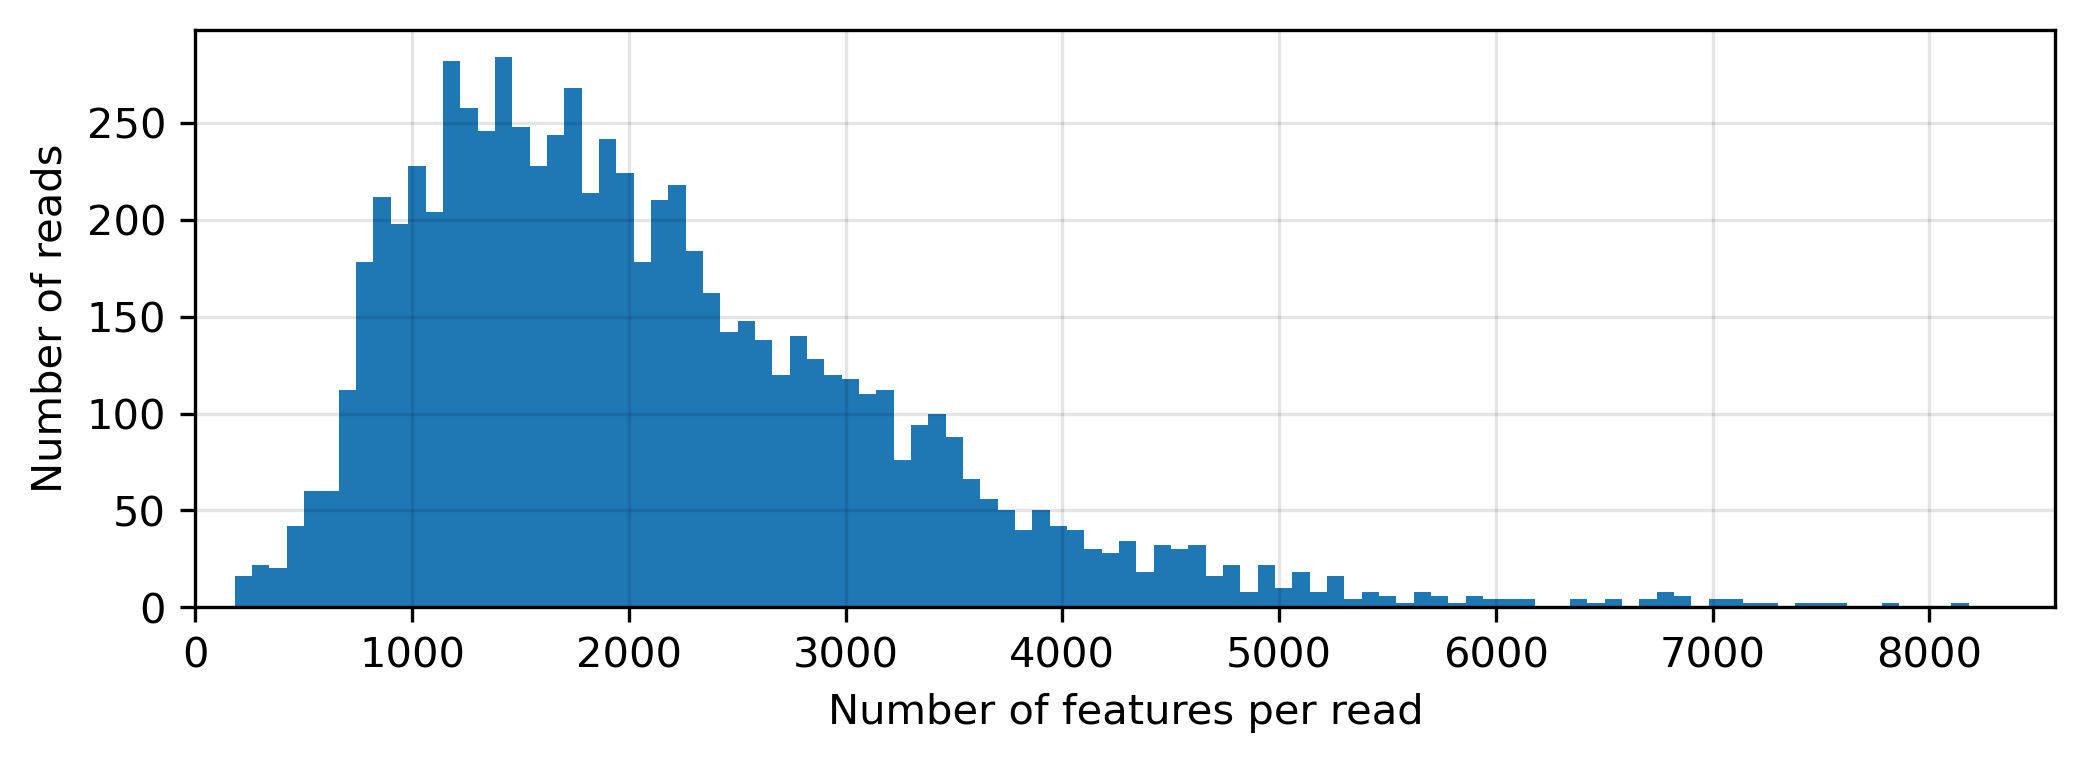

In [8]:
##绘制feature数目在reads中的分布图
fig, ax = plt.subplots(figsize=(8, 2.5))
ax.hist([len(x) for x in read_features.values()], bins=100)
ax.set_xlim(left=0)
ax.set_xlabel("Number of features per read")
ax.set_ylabel("Number of reads")
ax.grid(color='k', alpha=0.1)

In [9]:
feature_matrix.shape

(7448, 1265400)

In [ ]:
feature_matrix.sum() / (feature_matrix.shape[0] * feature_matrix.shape[1])

In [1]:
meta_df

NameError: name 'meta_df' is not defined

In [7]:
def get_read_intervals(meta_df):
    read_intervals = {
        i: [GenomicInterval(strand, start, end)]
        for i, strand, start, end in zip(
            meta_df.index,
            meta_df["reference_strand"],
            meta_df["reference_start"],
            meta_df["reference_end"],
        )
    }
    return read_intervals

read_intervals = get_read_intervals(meta_df)
len(read_intervals)

7448

In [8]:
%%time
reference_graph = OverlapGraph.from_intervals(read_intervals)
nr_edges = set((node_1, node_2) for node_1, node_2, data in reference_graph.edges(data=True) if not data['redundant'])
connected_component_count = len(list(nx.connected_components(reference_graph)))
len(reference_graph.nodes), len(reference_graph.edges), len(nr_edges), connected_component_count

CPU times: user 14 s, sys: 44.7 ms, total: 14.1 s
Wall time: 14.1 s


(7448, 150966, 14394, 2)

## Get nearest neighbours

In [ ]:
for i, config in enumerate(configs):
    print(i, config, sep='\t')

In [7]:
import faiss
my_embedding = scBiMapEmbedding()  
dim_redu_matrix = my_embedding.transform(data = feature_matrix,n_dimensions=500)


In [25]:
dim_copy = dim_redu_matrix.copy()
m = 8
nbits=8
seed=455390
feature_indices = np.random.default_rng(seed).choice(
                500, 496, replace=False, shuffle=False
            )
m_496d = dim_copy[:,feature_indices]
m_496d =m_496d.astype('float32')
Specifying order='C' 
m_496d = np.array(m_496d,order='C').astype('float32')



In [57]:
method = ['Exact_Euclidean','Exact_Cosine',
          'NNdescent_Euclidean','PQ_Euclidean','PQ_Cosine','HNSW_Euclidean','HNSW_Cosine',
          'MinHash_Jaccard','LowHash_Jaccard','WeightedMinHash_Jaccard','WeightedLowHash_Jaccard']

NameError: name 'Exact_Euclidean' is not defined

In [139]:
config = ['']
for i in configs:
    real_config = eval(i)

SyntaxError: positional argument follows keyword argument (<string>, line 11)

In [24]:
for i in range(len(simple_names)):
    add_to_dict = 'config_dict["'+simple_names[i]+'"]='+configs_str[i]
    print(add_to_dict)

config_dict["Exact_Euclidean_Spectural_100d_TF"]=NearestNeighborsConfig(
            nearest_neighbors_method=ExactNearestNeighbors,
            description=des,
            tfidf='TF',
            dimension_reduction_method=SpectralEmbedding,
            dimension_reduction_kw=dict(n_dimensions=100),
            nearest_neighbors_kw=dict(metric='euclidean'),
            **kw) 
config_dict["Exact_Euclidean_Spectural_100d_IDF"]=NearestNeighborsConfig(
            nearest_neighbors_method=ExactNearestNeighbors,
            description=des,
            tfidf='IDF',
            dimension_reduction_method=SpectralEmbedding,
            dimension_reduction_kw=dict(n_dimensions=100),
            nearest_neighbors_kw=dict(metric='euclidean'),
            **kw) 
config_dict["Exact_Euclidean_Spectural_100d_TF-IDF"]=NearestNeighborsConfig(
            nearest_neighbors_method=ExactNearestNeighbors,
            description=des,
            tfidf='TF-IDF',
            dimension_reduction_method=Spe

In [10]:
with open('/home/miaocj/docker_dir/kNN-overlap-finder/workflow/notebooks/config_dict.pkl', 'rb') as file:  
    config_dict = pickle.load(file)  

In [12]:
config = config_dict['NNDescent_Euclidean_Spectural_500d_TF-IDF']
config

KeyError: 'NNDescent_Euclidean_Spectural_500d_TF-IDF'

In [10]:
config= NearestNeighborsConfig(
            nearest_neighbors_method=HNSW,
            description='HNSW,Cosine,scBiMapEmbedding,500,None',
            tfidf='None',
            dimension_reduction_method=scBiMapEmbedding,
            dimension_reduction_kw=dict(n_dimensions=500),
            nearest_neighbors_kw=dict(metric='cosine'))
configs = [config]
print(config)

NearestNeighborsConfig(description='HNSW,Cosine,scBiMapEmbedding,500,None', tfidf='None', dimension_reduction_method=<class 'dim_reduction.scBiMapEmbedding'>, nearest_neighbors_method=<class 'nearest_neighbors.HNSW'>)


In [13]:
datas = np.load('/home/miaochangjiu/kNN-overlap-finder/data/evaluation/CHM13/HLA/pbsim_ONT_93_30k/kmer_k16/Exact_Euclidean_None_TF_nbr_matrix.npz',allow_pickle=True)
datas.files
nbr = datas['arr_0']

FileNotFoundError: [Errno 2] No such file or directory: '/home/miaochangjiu/kNN-overlap-finder/data/evaluation/CHM13/HLA/pbsim_ONT_93_30k/kmer_k16/Exact_Euclidean_None_TF_nbr_matrix.npz'

In [11]:
%%time
#configs = configs[:1]
configs = [config]
max_n_neighbors = COVERAGE_DEPTH
processes = threads

nbr_dict, time_dict, memory_dict = mp_compute_nearest_neighbors(
    data=feature_matrix,
    configs=configs,
    n_neighbors=max_n_neighbors,
    processes=processes,
)

Evaluating 1 configs using 8 processes.
0 Dimension reduction.
Nearest neighbors.
Finished NearestNeighborsConfig(description='HNSW,Cosine,scBiMapEmbedding,500,None', tfidf='None', dimension_reduction_method=<class 'dim_reduction.scBiMapEmbedding'>, nearest_neighbors_method=<class 'nearest_neighbors.HNSW'>). Elapsed time: {'dimension_reduction': 533.5163054466248, 'nearest_neighbors': 0.9135956764221191}. Peak memory: {}

CPU times: user 966 ms, sys: 92.1 ms, total: 1.06 s
Wall time: 8min 55s


In [48]:
if complete_name[0] == 'ExactNearestNeighbors':
            config = f'''NearestNeighborsConfig(
            nearest_neighbors_method={complete_name[0]},
            description="{des}",
            binarize=True,
            tfidf=True,
            dimension_reduction_method={complete_name[2]},
            dimension_reduction_kw=dict(n_dimensions={int(complete_name[3])}),
            nearest_neighbors_kw=dict(metric={complete_name[1]}),
            **kw)'''
        print(config)
    
mypq = ProductQuantization()
nbr_indices = mypq.get_neighbors(dim_redu_matrix,n_neighbors=20,metric="cosine")

WARNING clustering 7448 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 7448 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 7448 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 7448 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 7448 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 7448 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 7448 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 7448 points to 256 centroids: please provide at least 9984 training points


In [49]:
config = configs[0]
print(config)


NearestNeighborsConfig(description='{des}', binarize=False, tfidf='{complete_name[3]}', dimension_reduction_method=None, nearest_neighbors_method={'ExactNearestNeighbors'})


In [38]:
result = eval(config.strip()).get_neighbors(data=feature_matrix, n_neighbors=20)

TF transform.
Nearest neighbors.
Finished NearestNeighborsConfig(description='ExactNearestNeighbors,Euclidean,None,TF', binarize=False, tfidf='TF', dimension_reduction_method=None, nearest_neighbors_method=<class 'nearest_neighbors.ExactNearestNeighbors'>). Elapsed time: {'nearest_neighbors': 12.6636323928833}. Peak memory: {}


In [19]:

x ='NearestNeighborsConfig(\n            nearest_neighbors_method=ExactNearestNeighbors,\n            description=ExactNearestNeighbors,Euclidean,None,TF,\n            tfidf=TF,\n            nearest_neighbors_kw=dict(metric=euclidean),\n            **kw)'
print(x)

    NearestNeighborsConfig(
        nearest_neighbors_method=HNSW,
        description="HNSW (IDF, Spectral 100 dim.)",
        binarize=True,
        tfidf=True,
        dimension_reduction_method=SpectralEmbedding,
        dimension_reduction_kw=dict(n_dimensions=100),
        nearest_neighbors_kw=dict(metric="euclidean"),
        **kw
    )
NearestNeighborsConfig(
            nearest_neighbors_method=ExactNearestNeighbors,
            description=ExactNearestNeighbors,Euclidean,None,TF,
            tfidf=TF,
            nearest_neighbors_kw=dict(metric=euclidean),
            **kw)

NearestNeighborsConfig(
            nearest_neighbors_method=ExactNearestNeighbors,
            description=ExactNearestNeighbors,Euclidean,None,TF,
            tfidf=TF,
            nearest_neighbors_kw=dict(metric=euclidean),
            **kw)


## Statistics

In [23]:
read_ids = np.array(list(read_features))
graphs = collections.defaultdict(dict)
k_values = np.arange(2, max_n_neighbors + 1)
for i, config in enumerate(configs):
    print(i, end=" ")
    nbr_indices = nbr_dict[i]
    for k in k_values:
        graph = OverlapGraph.from_neighbor_indices(
            neighbor_indices=nbr_indices,
            n_neighbors=k,
            read_ids=read_ids,
            require_mutual_neighbors=False,
        )
        graphs[i][k] = graph

0 

In [26]:
df_rows = []
for i, config in enumerate(configs):
    print(i, end=' ')
    for k in k_values:
        graph = graphs[i][k]
        graph_stats = get_overlap_statistics(query_graph=graph, reference_graph=reference_graph)
        time_stats = {"elapsed_time:" + k: v for k, v in time_dict[i].items()}
        memory_stats = {"peak_memory:" + k: v for k, v in memory_dict[i].items()}
        
        stats = {"config_id": i, "description": config.description, "n_neighbors": k, 
                 **graph_stats, **time_stats, **memory_stats}
        df_rows.append(stats)
df = pd.DataFrame(df_rows)
df['connected_fraction'] = 1 - df['singleton_fraction']
df.to_csv(os.path.join(output_folder, "overlap_statistics.tsv"),  sep='\t')



0 

In [27]:
df

,config_id,description,n_neighbors,precision,nr_precision,recall,nr_recall,singleton_count,singleton_fraction,N50,elapsed_time:nearest_neighbors,label,connected_fraction
0,0,"ExactNearestNeighbors,Euclidean,None,TF",2,0.808132,0.317662,0.067406,0.277894,842,0.113050,50,13.484617,"0 ExactNearestNeighbors,Euclidean,None,TF",0.886950
1,0,"ExactNearestNeighbors,Euclidean,None,TF",3,0.774216,0.280081,0.096624,0.366611,644,0.086466,169,13.484617,"0 ExactNearestNeighbors,Euclidean,None,TF",0.913534
2,0,"ExactNearestNeighbors,Euclidean,None,TF",4,0.739272,0.247632,0.123021,0.432194,514,0.069012,358,13.484617,"0 ExactNearestNeighbors,Euclidean,None,TF",0.930988
3,0,"ExactNearestNeighbors,Euclidean,None,TF",5,0.711699,0.224315,0.148901,0.492219,425,0.057062,385,13.484617,"0 ExactNearestNeighbors,Euclidean,None,TF",0.942938
4,0,"ExactNearestNeighbors,Euclidean,None,TF",6,0.684823,0.203775,0.172814,0.539322,354,0.047530,752,13.484617,"0 ExactNearestNeighbors,Euclidean,None,TF",0.952470
5,0,"ExactNearestNeighbors,Euclidean,None,TF",7,0.662336,0.186856,0.196196,0.580520,311,0.041756,1222,13.484617,"0 ExactNearestNeighbors,Euclidean,None,TF",0.958244
6,0,"ExactNearestNeighbors,Euclidean,None,TF",8,0.640477,0.174058,0.217930,0.621162,246,0.033029,1733,13.484617,"0 ExactNearestNeighbors,Euclidean,None,TF",0.966971
7,0,"ExactNearestNeighbors,Euclidean,None,TF",9,0.621297,0.162898,0.239352,0.658191,217,0.029135,1740,13.484617,"0 ExactNearestNeighbors,Euclidean,None,TF",0.970865
8,0,"ExactNearestNeighbors,Euclidean,None,TF",10,0.602737,0.153128,0.259403,0.691191,189,0.025376,1866,13.484617,"0 ExactNearestNeighbors,Euclidean,None,TF",0.974624
9,0,"ExactNearestNeighbors,Euclidean,None,TF",11,0.584865,0.143644,0.278606,0.717660,153,0.020542,1872,13.484617,"0 ExactNearestNeighbors,Euclidean,None,TF",0.979458


In [31]:
df = pd.read_csv('/home/ecs-user/workspace/kNN-overlap-finder/data/evaluation/CHM13/HLA/pbsim_ONT_93_30k/kmer_k16/overlap_statistics.tsv', sep='\t') 

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


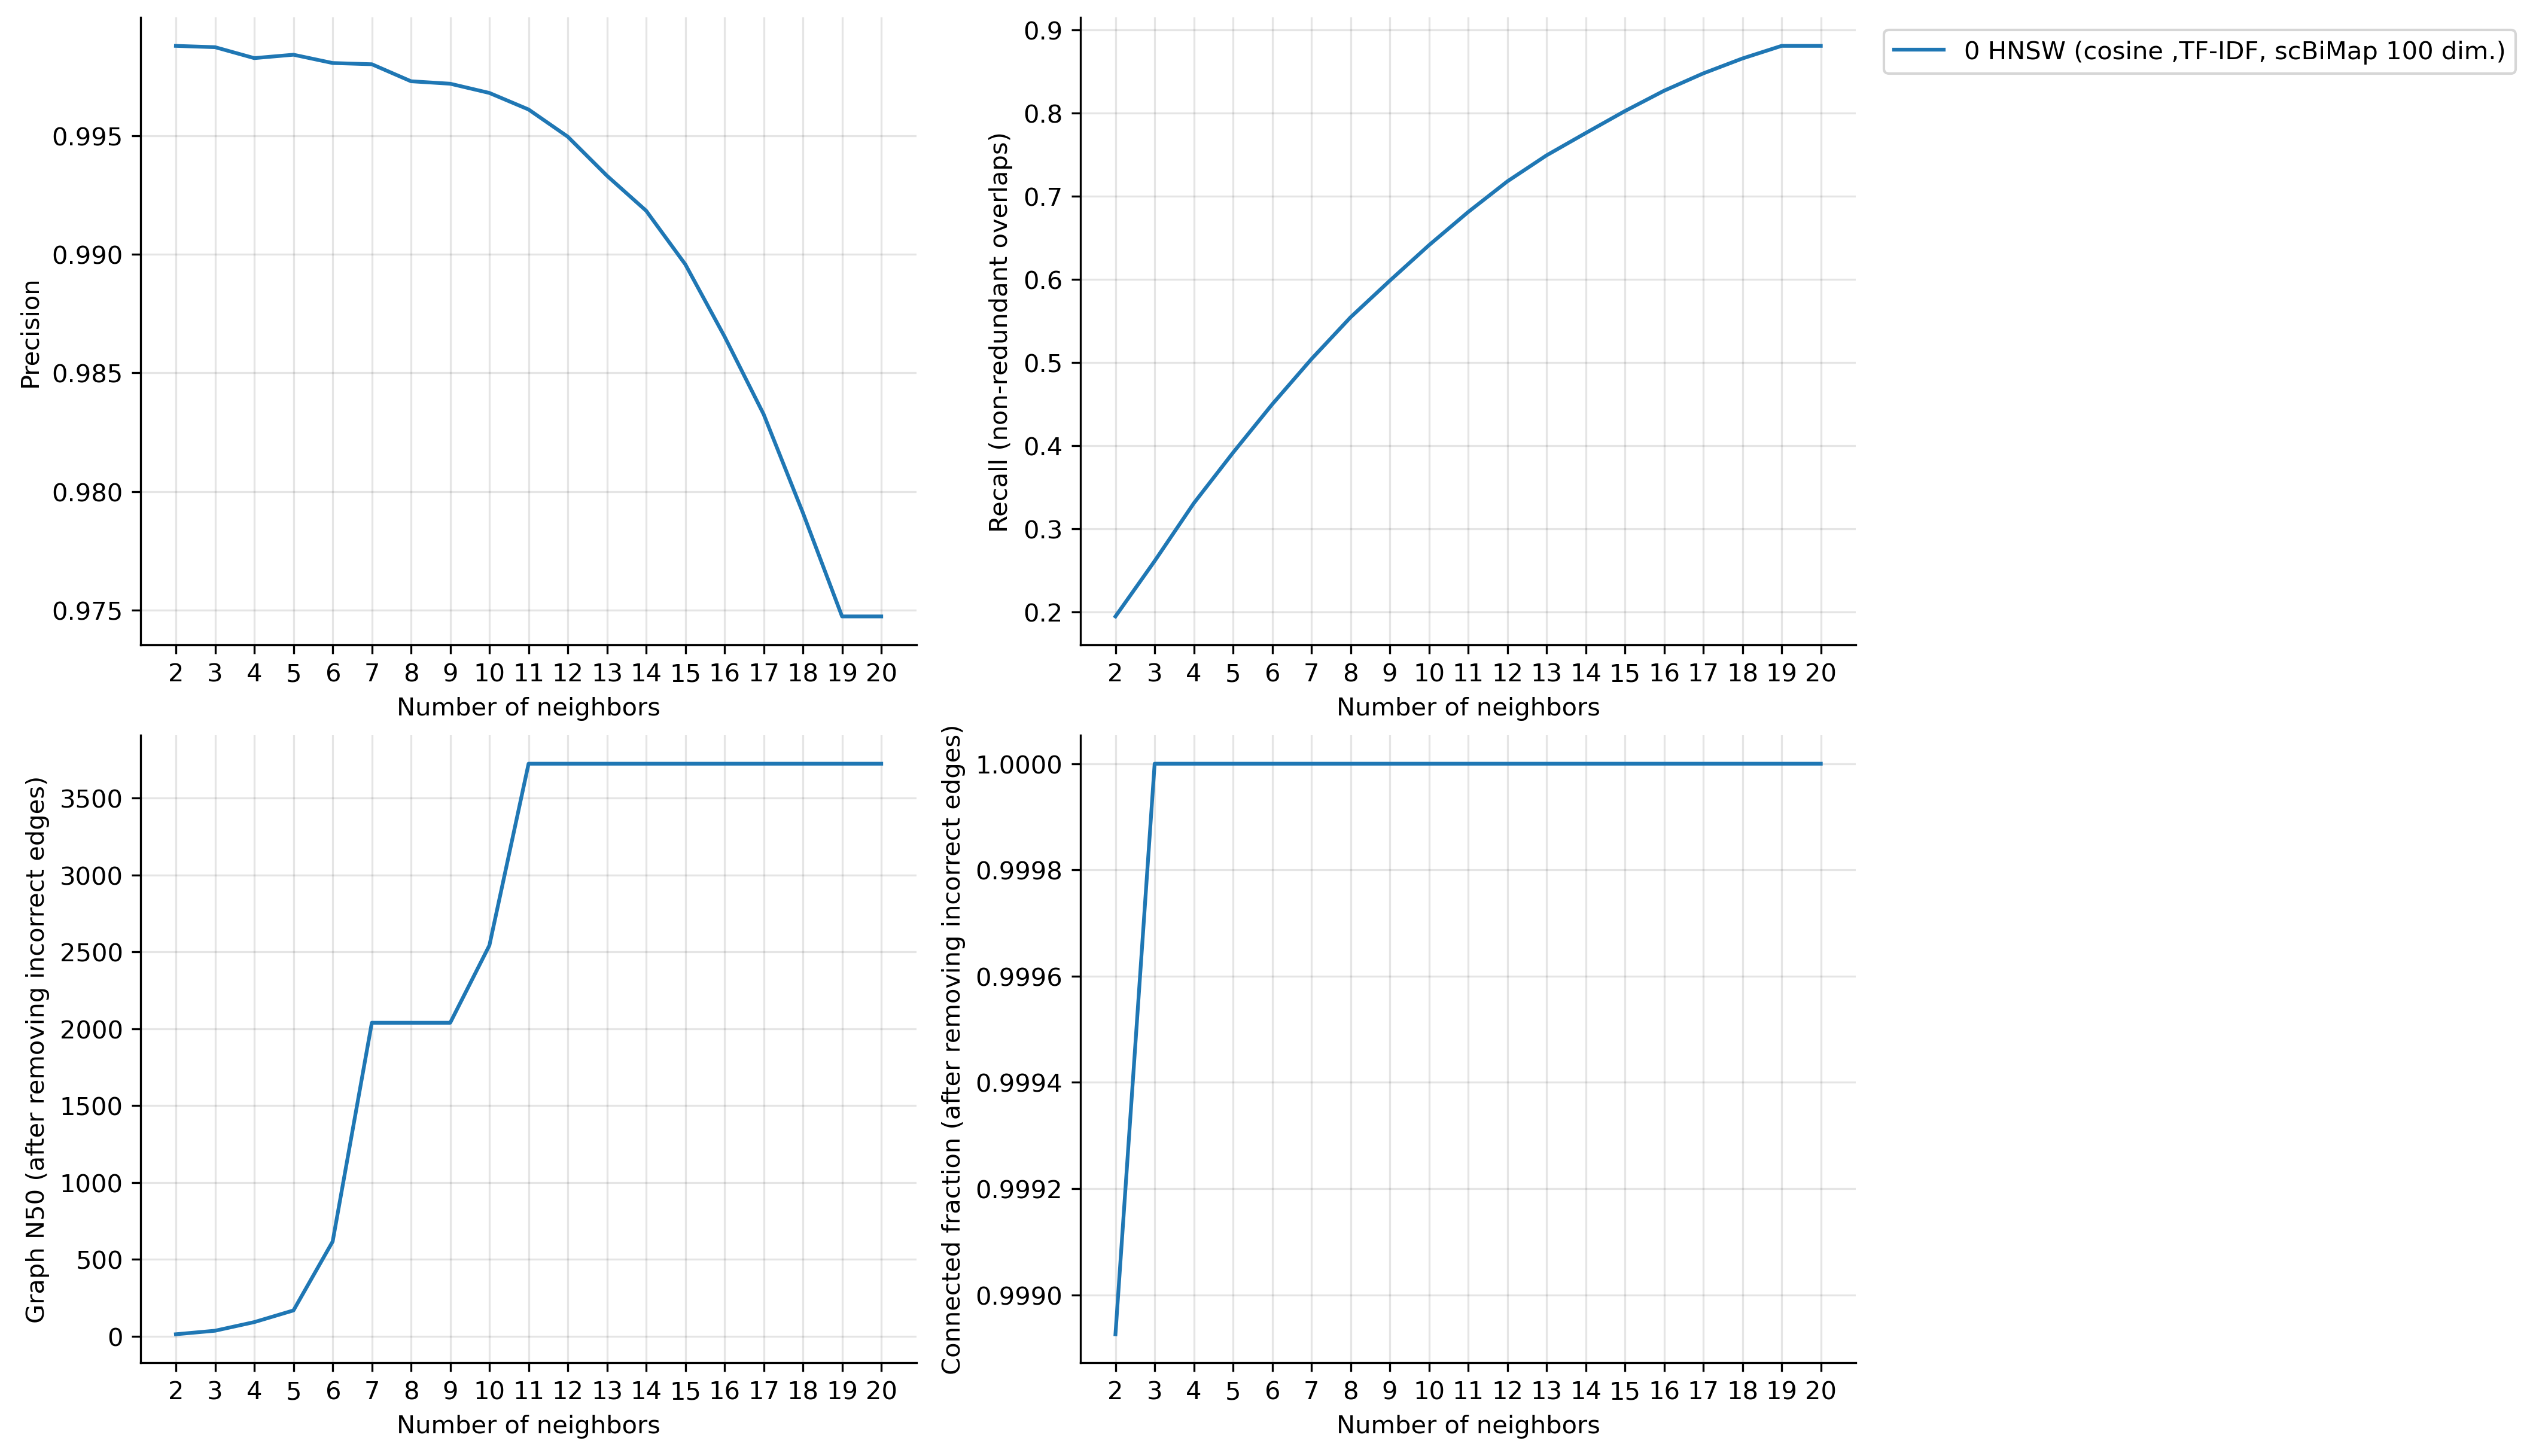

In [57]:
y_labels = dict(
    precision="Precision",
    nr_recall="Recall (non-redundant overlaps)",
    N50="Graph N50 (after removing incorrect edges)",
    connected_fraction="Connected fraction (after removing incorrect edges)"
)

if len(configs) <= 10:
    palette = "tab10"
elif len(configs) <= 20:
    palette = 'tab20'
else:
    palette = 'rainbow'

fig, axes = plt.subplots(2, 2, figsize=(14, 8), constrained_layout=True)
for i, ax in enumerate( itertools.chain(*axes) ):
    y = list(y_labels)[i]
    x = 'n_neighbors'
    hue = 'label'
    g = seaborn.lineplot(ax=ax, data=df, x=x, y=y, hue=hue, palette=palette)
    ax.set_xticks(k_values)
    ax.set_xlabel("Number of neighbors")
    ax.set_ylabel(y_labels[y])
    ax.grid(axis='both', color='k', alpha=0.1)

    if i == 1:
        ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1))
    else:
        ax.get_legend().remove()

    ax.spines[['top', 'right']].set_visible(False)

## Graph visualisation

In [58]:
def remove_small_components(graph, min_component_size=10):
    small_components = set()
    for component in nx.connected_components(graph):
        if len(component) < min_component_size:
            small_components |= component
    graph.remove_nodes_from(small_components)
            
    
def plot_graphs(graphs, reference_graph, metadata, *, min_component_size=10, 
                processes=8, layout_method='stdp', figsize=(6, 6), node_size=3,
    seed: int = 4829, verbose=True):
    axes = []
    figures = []

    new_graphs = []
    for g in graphs:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
        figures.append(fig)
        ax1.set_title("All edges")
        ax2.set_title("Correct edges")
        
        g = g.copy()
        remove_small_components(g, min_component_size=min_component_size)
        new_graphs.append(g)
        axes.append(ax1)

        g = g.copy()
        remove_false_edges(g, reference_graph)
        remove_small_components(g, min_component_size=min_component_size)
        new_graphs.append(g)
        axes.append(ax2)

    for fig, config in zip(figures, configs):
        fig.suptitle(str(config), ha="center", va="bottom", wrap=True, size=7)

    query_graphs = new_graphs
    def plot(i, pos):
        plot_read_graph(
            ax=axes[i],
            query_graph=query_graphs[i],
            reference_graph=reference_graph,
            metadata=metadata,
            pos=pos,
            node_size=node_size,
        )

    with sharedmem.MapReduce(np=processes) as pool:

        def work(i):
            if layout_method == "umap":
                pos = get_umap_layout(graph=query_graphs[i])
            else:
                pos = get_graphviz_layout(
                    graph=query_graphs[i],
                    figsize=figsize,
                    seed=seed,
                    layout_method=layout_method,
                )
            return i, pos

        def reduce(i, pos):
            if verbose:
                print(i, end=" ")
            plot(i, pos)

        pool.map(work, range(len(query_graphs)), reduce=reduce)
        if verbose:
            print("")

    return figures

0 1 
CPU times: user 4.37 s, sys: 116 ms, total: 4.49 s
Wall time: 38.6 s


[<Figure size 3600x1800 with 2 Axes>]

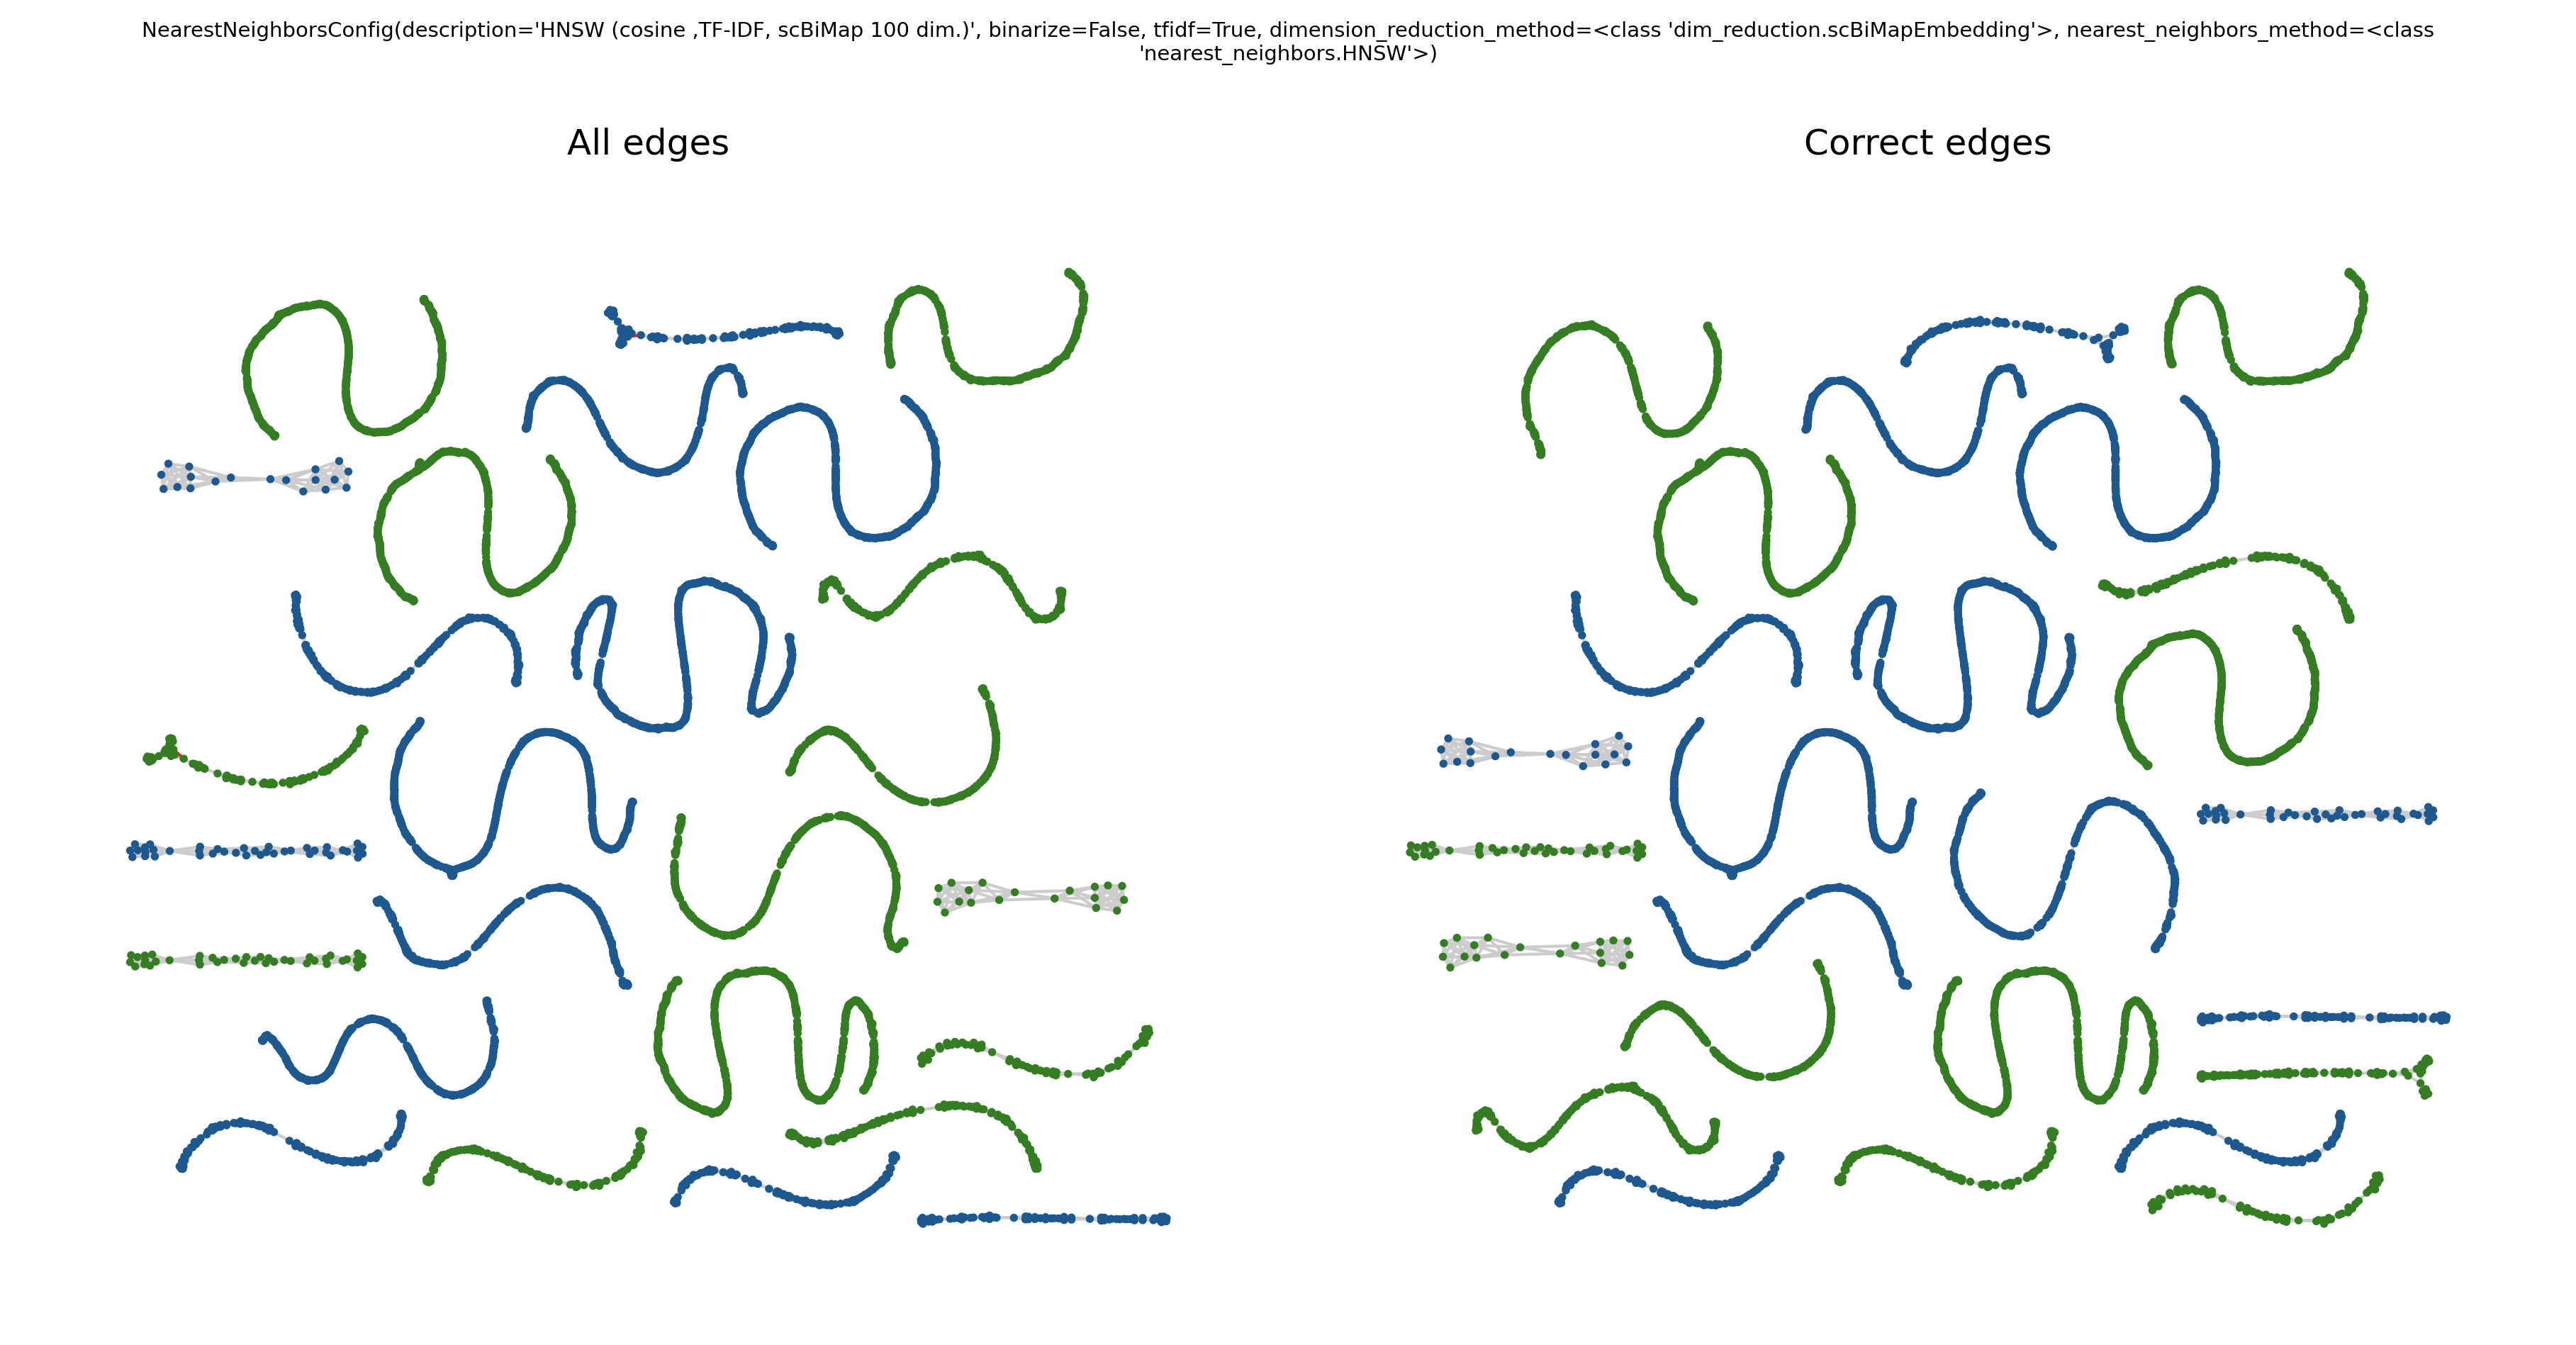

In [59]:
%%time
k6_graphs = [graphs[i][6] for i in range(len(graphs))]
plot_graphs(
    k6_graphs, reference_graph=reference_graph, metadata=meta_df, layout_method="sfdp", processes=threads
)

In [ ]:
%%time
k12_graphs = [graphs[i][6] for i in range(len(graphs))]
plot_graphs(
    k12_graphs, reference_graph=reference_graph, metadata=meta_df, layout_method="sfdp", processes=threads
)

In [ ]:
kw = dict(data=feature_matrix)
max_bucket_size = COVERAGE_DEPTH * 1.5

configs = [
    
    NearestNeighborsConfig(
        nearest_neighbors_method=ProductQuantization,
        description="PQ (TF-IDF,scBiMap 100 dim.)",
        binarize=False,
        tfidf=True,
        dimension_reduction_method=scBiMapEmbedding,
        dimension_reduction_kw=dict(n_dimensions=100),
        nearest_neighbors_kw=dict(nbits=6,metric = "cosine"),
        **kw
    ),]
wait_configs = [
    NearestNeighborsConfig(
        nearest_neighbors_method=ProductQuantization,
        description="PQ (TF-IDF,scBiMap 100 dim.)",
        binarize=False,
        tfidf=True,
        dimension_reduction_method=scBiMapEmbedding,
        dimension_reduction_kw=dict(n_dimensions=100),
        nearest_neighbors_kw=dict(nbits=6,metric = "cosine"),
        **kw
    ),
    NearestNeighborsConfig(
        nearest_neighbors_method=IVFProductQuantization,
        description="IVFPQ (TF-IDF,scBiMap 100 dim.)",
        binarize=False,
        tfidf=True,
        dimension_reduction_method=scBiMapEmbedding,
        dimension_reduction_kw=dict(n_dimensions=100),
        nearest_neighbors_kw=dict(nbits=6,metric = "cosine"),
        **kw
    ),]
oldconfigs = [
    
    # Minimap2 all-vs-all
    NearestNeighborsConfig(
        nearest_neighbors_method=PAFNearestNeighbors,
        description="Minimap2 all-vs-all",
        nearest_neighbors_kw=dict(paf_path=paf_path, read_indices=read_indices),
        **kw
    ),
    
    # DimReduction + HNSW 
    NearestNeighborsConfig(
        nearest_neighbors_method=HNSW,
        description="HNSW (IDF, Spectral 100 dim.)",
        binarize=True,
        tfidf=True,
        dimension_reduction_method=SpectralEmbedding,
        dimension_reduction_kw=dict(n_dimensions=100),
        nearest_neighbors_kw=dict(metric="euclidean"),
        **kw
    ),
    NearestNeighborsConfig(
        nearest_neighbors_method=HNSW,
        description="HNSW (IDF, Spectral 500 dim.)",
        binarize=True,
        tfidf=True,
        dimension_reduction_method=SpectralEmbedding,
        dimension_reduction_kw=dict(n_dimensions=500),
        nearest_neighbors_kw=dict(metric="euclidean"),
        **kw
    ),
    NearestNeighborsConfig(
        nearest_neighbors_method=HNSW,
        description="HNSW (IDF, scBiMap 100 dim.)",
        binarize=True,
        tfidf=True,
        dimension_reduction_method=scBiMapEmbedding,
        dimension_reduction_kw=dict(n_dimensions=100),
        nearest_neighbors_kw=dict(metric="euclidean"),
        **kw
    ),
    NearestNeighborsConfig(
        nearest_neighbors_method=HNSW,
        description="HNSW (IDF, scBiMap 500 dim.)",
        binarize=True,
        tfidf=True,
        dimension_reduction_method=scBiMapEmbedding,
        dimension_reduction_kw=dict(n_dimensions=500),
        nearest_neighbors_kw=dict(metric="euclidean"),
        **kw
    ),
    NearestNeighborsConfig(
        nearest_neighbors_method=HNSW,
        description="HNSW (TF-IDF, Spectral 100 dim.)",
        tfidf=True,
        dimension_reduction_method=SpectralEmbedding,
        dimension_reduction_kw=dict(n_dimensions=100),
        nearest_neighbors_kw=dict(metric="euclidean"),
        **kw
    ),
    NearestNeighborsConfig(
        nearest_neighbors_method=HNSW,
        description="HNSW (TF-IDF, scBiMap 100 dim.)",
        tfidf=True,
        dimension_reduction_method=scBiMapEmbedding,
        dimension_reduction_kw=dict(n_dimensions=100),
        nearest_neighbors_kw=dict(metric="euclidean"),
        **kw
    ),
    # LowHash
    NearestNeighborsConfig(
        nearest_neighbors_method=LowHash,
        description="LowHash (binary)",
        tfidf=False,
        nearest_neighbors_kw=dict(
            lowhash_fraction=0.01,
            max_bucket_size=max_bucket_size,
            repeats=100,
            seed=458,
        ),
        **kw
    ),
    NearestNeighborsConfig(
        nearest_neighbors_method=LowHash,
        description="MinHash (binary)",
        tfidf=False,
        nearest_neighbors_kw=dict(
            lowhash_count=20,
            max_bucket_size=max_bucket_size,
            repeats=100,
            seed=458,
        ),
        **kw
    ),
    
    # Weighted LowHash
    NearestNeighborsConfig(
        nearest_neighbors_method=WeightedLowHash,
        description="Weighted LowHash (TF)",
        tfidf=False,
        nearest_neighbors_kw=dict(
            lowhash_fraction=0.01,
            max_bucket_size=max_bucket_size,
            repeats=100,
            seed=458,
        ),
        **kw
    ),
    NearestNeighborsConfig(
        nearest_neighbors_method=WeightedLowHash,
        description="Weighted LowHash (IDF)",
        binarize=True,
        tfidf=True,
        nearest_neighbors_kw=dict(
            lowhash_fraction=0.01,
            max_bucket_size=max_bucket_size,
            repeats=100,
            seed=458,
        ),
        **kw
    ),
    NearestNeighborsConfig(
        nearest_neighbors_method=WeightedLowHash,
        description="Weighted LowHash (TF-IDF)",
        tfidf=True,
        nearest_neighbors_kw=dict(
            lowhash_fraction=0.01,
            max_bucket_size=max_bucket_size,
            repeats=100,
            seed=458,
        ),
        **kw
    ),
    
    NearestNeighborsConfig(
        nearest_neighbors_method=WeightedLowHash,
        description="Weighted MinHash (TF)",
        tfidf=False,
        nearest_neighbors_kw=dict(
            lowhash_count=20,
            max_bucket_size=max_bucket_size,
            repeats=100,
            seed=458,
        ),
        **kw
    ),
    NearestNeighborsConfig(
        nearest_neighbors_method=WeightedLowHash,
        description="Weighted MinHash (IDF)",
        binarize=True,
        tfidf=True,
        nearest_neighbors_kw=dict(
            lowhash_count=20,
            max_bucket_size=max_bucket_size,
            repeats=100,
            seed=458,
        ),
        **kw
    ),
    NearestNeighborsConfig(
        nearest_neighbors_method=WeightedLowHash,
        description="Weighted MinHash (TF-IDF)",
        tfidf=True,
        nearest_neighbors_kw=dict(
            lowhash_count=20,
            max_bucket_size=max_bucket_size,
            repeats=100,
            seed=458,
        ),
        **kw
    ),
]


small_data_configs = [
    # PQ
    NearestNeighborsConfig(
        nearest_neighbors_method=ProductQuantization,
        description="PQ (IDF, 100 dim.)",
        binarize=True,
        tfidf=True,
        dimension_reduction_method=SpectralEmbedding,
        dimension_reduction_kw=dict(n_dimensions=100),
        nearest_neighbors_kw=dict(nbits=6),
        **kw
    ),
    NearestNeighborsConfig(
        nearest_neighbors_method=ProductQuantization,
        description="PQ (TF-IDF, 100 dim.)",
        binarize=False,
        tfidf=True,
        dimension_reduction_method=SpectralEmbedding,
        dimension_reduction_kw=dict(n_dimensions=100),
        nearest_neighbors_kw=dict(nbits=6),
        **kw
    ),
    # NNdescent
    NearestNeighborsConfig(
        nearest_neighbors_method=NNDescent,
        description="NNdescent (IDF)",
        binarize=True,
        tfidf=True,
        dimension_reduction_method=None,
        nearest_neighbors_kw=dict(metric="euclidean", n_jobs=None),
        **kw
    ),
    NearestNeighborsConfig(
        nearest_neighbors_method=NNDescent,
        description="NNdescent (TF-IDF)",
        tfidf=True,
        dimension_reduction_method=None,
        nearest_neighbors_kw=dict(metric="euclidean", n_jobs=None),
        **kw
    ),
    # Exact Euclidean
    NearestNeighborsConfig(
        nearest_neighbors_method=ExactNearestNeighbors,
        description="Exact Euclidean (binary)",
        binarize=True,
        tfidf=False,
        dimension_reduction_method=None,
        nearest_neighbors_kw=dict(metric="euclidean"),
        **kw
    ),
    NearestNeighborsConfig(
        nearest_neighbors_method=ExactNearestNeighbors,
        description="Exact Euclidean (TF)",
        tfidf=False,
        dimension_reduction_method=None,
        nearest_neighbors_kw=dict(metric="euclidean"),
        **kw
    ),
    NearestNeighborsConfig(
        nearest_neighbors_method=ExactNearestNeighbors,
        description="Exact Euclidean (IDF)",
        binarize=True,
        tfidf=True,
        dimension_reduction_method=None,
        nearest_neighbors_kw=dict(metric="euclidean"),
        **kw
    ),
    NearestNeighborsConfig(
        nearest_neighbors_method=ExactNearestNeighbors,
        description="Exact Euclidean (TF-IDF)",
        tfidf=True,
        dimension_reduction_method=None,
        nearest_neighbors_kw=dict(metric="euclidean"),
        **kw
    ),
    NearestNeighborsConfig(
        nearest_neighbors_method=ExactNearestNeighbors,
        description="Exact Euclidean (IDF, Spectral 100 dim.)",
        binarize=True,
        tfidf=True,
        dimension_reduction_method=SpectralEmbedding,
        dimension_reduction_kw=dict(n_dimensions=100),
        nearest_neighbors_kw=dict(metric="euclidean"),
        **kw
    ),
    NearestNeighborsConfig(
        nearest_neighbors_method=ExactNearestNeighbors,
        description="Exact Euclidean (IDF, Spectral 500 dim.)",
        binarize=True,
        tfidf=True,
        dimension_reduction_method=SpectralEmbedding,
        dimension_reduction_kw=dict(n_dimensions=500),
        nearest_neighbors_kw=dict(metric="euclidean"),
        **kw
    ),
    NearestNeighborsConfig(
        nearest_neighbors_method=ExactNearestNeighbors,
        description="Exact Euclidean (TF-IDF, Spectral 100 dim.)",
        tfidf=True,
        dimension_reduction_method=SpectralEmbedding,
        dimension_reduction_kw=dict(n_dimensions=100),
        nearest_neighbors_kw=dict(metric="euclidean"),
        **kw
    ),
    NearestNeighborsConfig(
        nearest_neighbors_method=ExactNearestNeighbors,
        description="Exact Euclidean (IDF, scBiMap 100 dim.)",
        binarize=True,
        tfidf=True,
        dimension_reduction_method=scBiMapEmbedding,
        dimension_reduction_kw=dict(n_dimensions=100),
        nearest_neighbors_kw=dict(metric="euclidean"),
        **kw
    ),
    NearestNeighborsConfig(
        nearest_neighbors_method=ExactNearestNeighbors,
        description="Exact Euclidean (IDF, scBiMap 500 dim.)",
        binarize=True,
        tfidf=True,
        dimension_reduction_method=scBiMapEmbedding,
        dimension_reduction_kw=dict(n_dimensions=500),
        nearest_neighbors_kw=dict(metric="euclidean"),
        **kw
    ),
    NearestNeighborsConfig(
        nearest_neighbors_method=ExactNearestNeighbors,
        description="Exact Euclidean (TF-IDF, scBiMap 100 dim.)",
        tfidf=True,
        dimension_reduction_method=scBiMapEmbedding,
        dimension_reduction_kw=dict(n_dimensions=100),
        nearest_neighbors_kw=dict(metric="euclidean"),
        **kw
    ),
]

#if feature_matrix.shape[0] <= 20_000:
#    configs += small_data_configs